<a href="https://colab.research.google.com/github/chchang1990/fierpy/blob/main/HydraFloods_RESTEE_FIERpy_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIER in Bangladesh

**This notebook test implementation of FIER in Bangladesh**
1.   Install/import HydraFloods
2.   Install/import RESTEE
3.   Choose S1 images with specific path/frame and import from GEE
4.   HydraFloods - Filtering, Slope correction
5.   Use RESTEE to generate image stack - xarray dataset
6.   Install/import FIERpy



In [2]:
# mount the google drive so that we can save credentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install HydraFloods, RESTEE and FIERpy

Note that when installing on local PC, 
**GDAL, rasterio, fiona** highly possibly need to be installed by using source wheeler files which can be obtained from:
https://www.lfd.uci.edu/~gohlke/pythonlibs/#rasterio

Then in your virtual environment prompt , use:
pip install PATH_OF_WHEELER

In [81]:
# ----- For HydraFloods, RESTEE -----
!pip install \
    hydrafloods \
    geemap \
    numpy \
    scipy \
    pandas \
    xarray \
    rasterio \
    geopandas \
    pyproj \
    requests \
    backoff \
    tqdm \
    restee \
    pyyaml==3.13 \
    tornado~=5.1.0

# ----- For FIERpy -----
!pip install \
     netcdf4 \
     python-qt \
     rioxarray \
     numpy \
     scipy \
     xarray \
     pandas \
     scikit-learn \
     eofs \
     geoglows \
     git+https://github.com/servir/fierpy.git    

  Cloning https://github.com/servir/fierpy.git to /tmp/pip-req-build-5zc_84k7
  Running command git clone -q https://github.com/servir/fierpy.git /tmp/pip-req-build-5zc_84k7
     |████████████████████████████████| 46 kB 1.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 10.0 MB/s 
     |████████████████████████████████| 15.6 MB 195 kB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 23.9 MB 9.6 kB/s 
  Created wheel for fierpy: filename=fierpy-0.0.4-py3-none-any.whl size=7202 sha256=12312ecb598e828378d6d397099f26d5082987dc2302edaa0b82d927f451dccd
  Stored in directory: /tmp/pip-ephem-wheel-cache-95kefvuh/wheels/1d/19/65/455814924955849eb4e5dc4c32f73317ec4e24a5d37d2fc5b4
  Created wheel for python-qt: filename=python_qt-0.50-py3-none-any.whl size=2689 sha256=f9169bb6bc7cda8aed69887e5de416d49bc3f2c2686a9302

In [8]:
import hydrafloods as hf
from hydrafloods import ml
from hydrafloods import timeseries

In [9]:
import ee
import geemap
import restee as ree
PROJECT_ID="fier-314819"
CREDENTIAL="/content/fier-314819-267d62ad4e0b.json"

_ = geemap.Map()
ee.Initialize()

In [10]:
%pylab inline
import datetime


Populating the interactive namespace from numpy and matplotlib


Some customized funciton in case needed

In [11]:
# Usage: HydraFloodsDataset = HydraFloodsDataset.apply_func(img_col_clip, aoi=region)
def img_col_clip(image, aoi):
  return image.clip(aoi)

**Define Area of Interest (AOI)**

For now, some manual work is needed in order to get images from specific Path/Frame. This requires carefully define AOI, time span, relative orbit number. These can be visually check from ASF Data Vertex.

Later, we may need to find out how to do it more efficiently

In [12]:
lon_w = 89.14
lat_s = 24.05
lon_e = 91.25
lat_n = 24.94
AOI = ee.Geometry.Rectangle(lon_w, lat_s, lon_e, lat_n)
 

In [13]:
RelOrb = 150
st_time = '2017-03-21'
ed_time = '2019-12-31'

S1_AOI = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(AOI)
    .filterDate(st_time,ed_time)    
    # With specific "relative orbit number" and the pre-defined AOI, and
    # time frame, it is possible restrict the images to be of the same path and frame
    # But such information has to be manually checked on ASF Vertex 
    # (Or maybe there is a way to get the FrameID directly, but need to find out)
    .filterMetadata('relativeOrbitNumber_start','equals',RelOrb)
    .filterMetadata('relativeOrbitNumber_stop','equals',RelOrb)  
    .filterMetadata('platform_number','equals','A')
)
#S1_AOI.getInfo()
S1_AOI.size().getInfo()
# ----- If want to loop over each images -----
# img_list = ee.Image(S1_AOI.toList(S1_AOI.size()))




76

**HydraFloods**

Convert GEE Image Collection to HydraFloods dataset for 
1.  Slope correction
2.  Filter

In [14]:
hf_S1_AOI=hf.datasets.Dataset.from_imgcollection(S1_AOI)

In [15]:
rtc_hf_S1_AOI = hf_S1_AOI.apply_func(hf.slope_correction, elevation=ee.Image('MERIT/DEM/v1_0_3'))
filt_rtc_hf_S1_AOI=rtc_hf_S1_AOI.apply_func(hf.gamma_map)



**RESTEE**

Use RESTEE to convert GEE ImageCollection to Xarray dataset

In [56]:
lon_w = 88.62
lat_s = 23.45
lon_e = 91.5
lat_n = 25.47
RESTEE_AOI = ee.Geometry.Rectangle(lon_w, lat_s, lon_e, lat_n)

session=ree.EESession(PROJECT_ID, CREDENTIAL)
region = RESTEE_AOI
domain = ree.Domain.from_ee_geometry(session, region, resolution=0.01) #unit of resolution is degree

In [73]:
from math import nan
img_stack_temp = ree.imgcollection_to_xarray(session, domain, S1_AOI, bands=['VV']) 
# Note that the pixel grid dimension limitation is up to 10000, 
# total request size is up to 33554432 bytes, 
# the resolution, and the extent of study area/time can be limited by these


In [74]:
# Sort dataset with time and reformat time string
img_stack_temp = img_stack_temp.sortby('time')
img_stack_temp['time'] = img_stack_temp['time'].dt.strftime('%Y-%m-%d')


In [75]:
# Make pixels with value = 0 as NaN
img_stack_temp = img_stack_temp.where(img_stack_temp['VV']!=0.)

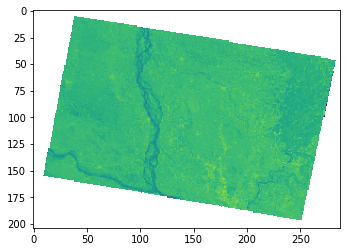

In [76]:
#for i in range(S1_AOI.size().getInfo()):
#  plt.imshow(img_stack_temp['VV'][i])
#  plt.show()

plt.imshow(img_stack_temp['VV'][0])
plt.show()

In [77]:
img_stack_temp['VV'][0]

<xarray.DataArray 'VV' (lat: 204, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     <U10 '2017-03-21'
  * lon      (lon) float64 88.62 88.64 88.65 88.66 ... 91.47 91.48 91.49 91.5
  * lat      (lat) float64 25.48 25.47 25.46 25.45 ... 23.48 23.47 23.46 23.45

Make sure each pixel location consistently has data over time, otherwise set it as NaN

In [79]:
n_lat, n_lon = np.shape(img_stack_temp['VV'])[1], np.shape(img_stack_temp['VV'])[2]

# Find (lat, lon) where has at least one NaN in time
img_stack_mean = img_stack_temp.mean(dim='time', skipna=False, keep_attrs=True)
indx_img_stack_null = img_stack_mean.isnull(keep_attrs=True)
img_stack = img_stack_temp.where(~indx_img_stack_null['VV'])

**FIERpy**